In [ ]:
## 패키지 설치
pip install nltk konlpy pandas networkx gensim

In [ ]:
## 코랩 한글 깨짐 현상 해결
## [방법 1]
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


## [방법 2] 나눔고딕 설치
# !apt -qq -y install fonts-nanum > /dev/null

# import matplotlib.font_manager as fm
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
# # fm._rebuild()

# # 그래프에 retina display 적용
# %config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import pandas as pd
from pandas import DataFrame

In [3]:
## 1. 
## [함수 정의] #################################################################
## 탐색하고자 하는 대상이 단어인가 문서인가에 따라 TF와 DF로 나뉨 ##############
## tf (term frequency) : 1개 문서 내 특정 단어 빈도
def tf(term, document):
    return document.count(term)


docs = []

## df (document frequency) : 특정 단어가 나타나는 문서의 개수
def df(term):
    df = 0
    for doc in docs:
        df += term in doc
    return df

## IDF (Inverse Document Frequency) : DF에서 역수 변환
## d : 문서, t : 단어, n : 문서 총 개수
def idf(term):
    return log(N/(df(term)+1))

## tf_idf : 많이 등장하는 단어에 패널티를 주고 단어 빈도의 스케일을 맞춰주는 방법
## 수식으로는 TF-IDF = tf*idf
def tf_idf(term, document):
    return tf(term, document) * idf(term)

In [ ]:
####################################################################################################
## Code start ######################################################################################
####################################################################################################
from nltk.tokenize import sent_tokenize
from konlpy.corpus import kolaw
from konlpy.tag import *
from pandas import DataFrame
from math import log

import konlpy
import nltk
import pandas as pd

## 파일 읽어오기 #######################################################
## 1) 코랩에 파일 업로드
# from google.colab import files
# myfile = files.upload()

## 2) 제1기 csv 파일 읽어오기
current_work = 'time_1.csv'
table_1 = pd.read_csv(current_work)
# table_1
# type(table_1)        ## DataFrame

In [6]:
table_1[['등록일', '언론사', '기사제목']][:50]

,등록일,언론사,기사제목
0,2020.01.31.,부산일보언론사 선정,[전국 신종 코로나 현황] 확진환자 11명 정리(31일 오후 2시)
1,2020.01.31.,세계일보,수원 권선구 호매실동 시립금호어울림어린이집 폐쇄..원생 19명 ‘능동감시자...
2,2020.01.31.,경향신문언론사 선정,보스턴심포니 첫 내한공연 무산…신종 코로나바이러스 확산 우려
3,2020.01.31.,뉴스1,"모모랜드, 신종 코로나 여파로 3월 日 팬미팅 잠정 연기"
4,2020.01.31.,뉴시스언론사 선정,일본서 '신종 코로나' 확진자 14명으로 늘어
5,2020.01.31.,연합뉴스,"태국서 신종코로나 첫 '2차 감염'…""중국 방문 안 한 택시기사"""
6,2020.01.31.,연합뉴스,'주민 신종코로나 확진' 군산 모든 학교 졸업식 연기
7,2020.01.31.,이데일리,국내 '신종코로나' 확진자 4명 추가 발생…총 11명
8,2020.01.30.,연합뉴스언론사 선정,또 무증상 전파? 중국서 동창회 참석 6명 신종코로나 동시 확진
9,2020.01.31.,연합뉴스,"중국 연구진 ""신종코로나, 남자가 여자보다 더 잘 걸려"""


In [7]:
row, col = table_1.shape

news_content = table_1['기사제목']  ## Object
#news_content

news_content_list = list(news_content)
# news_content_list

## 자료형 변환 : list -> str
# news_content_str = ' '.join(news_content_list)
news_content_str = ' '.join(map(str, news_content_list))

In [8]:
'''
nouns : 명사 추출
morphs : 형태소 추출
pos : 품사 부착
'''
komoran = Komoran()

## 메모리 설정
# konlpy.jvm.init_jvm(jvmpath=None, max_heap_size=1024)

## 형태소와 품사 추출 ######################################################################
# pos = komoran.pos(news_content_str)
# pos

'''
NNB: '의존 명사',
NNG: '일반 명사',
NNP: '고유 명사',
NP : '대명사',
'''

## 7분 29초 소요 ############################################################################

"\nNNB: '의존 명사',\nNNG: '일반 명사',\nNNP: '고유 명사',\nNP : '대명사',\n"

In [ ]:
kopus = []
token_result = []

#############################################################################################################
## 불용어 처리 : 단어 제외하기 ########################################################################

stop_word = ['로나', '19', '째 코', '10', '20', '11', '100', '진자', '50', '위해']

for line in news_content_list:
    pos = komoran.pos(line)
    NN = [element[0] for element in pos if element[1] in ('NNP', 'NNG')]
    # print('NN >>', NN)

    NN_copy = NN[:]

    for N in NN:
      # print('N >>', N)

      if N in stop_word:
        NN_copy.remove(N)

      if len(N) == 1:
        NN_copy.remove(N)

    # print('NN : 불용어 삭제 후 >>', NN)

    token_result.append(NN_copy)
    kopus.extend(NN_copy)
        
# print('=' * 100)    
# kopus


In [59]:
#######################################################################################################
# docs = list(test_file['기사내용'])
docs = news_content_list

# ## 총 문서 수
# N = len(docs)
N = row

## 중복 제거한 형태소 #################################################################################
voca = list(set(kopus))
# print('중복 제거한 형태소 개수 >>', len(voca))
# voca

# print(docs)
print('docs 수 >>', len(docs))
print('N 수 >>', N)
print('형태소 개수 : voca 수 >>', len(voca))

## IDF -------------------------------------------------------------------------------
# IDE_result = []

# for t in final_voca:
#     IDE_result.append(idf(t))

# IDE_result

# idf_ = pd.DataFrame(IDE_result, index=final_voca, columns=["IDF"])
# idf_
# idf_.IDF.sort_values(ascending=False)[:30]

## tf_idf -----------------------------------------------------------------------------
TF_IDE_result = []

for word in voca:
#     print(word)
    TF_IDE_result.append(tf_idf(word, news_content_str))
    
# TF_IDE_result

tf_idf_ = pd.DataFrame(TF_IDE_result, index=voca, columns=["IDF"])
# tf_idf_

tf_idf_final = tf_idf_.sort_values(by='IDF', ascending=False)[:30]  ## 최종 30개 형태소 추출
tf_idf_final.to_csv(f'{current_work}_tf_idf.csv')
print(f'{current_work}_tf_idf.csv 파일 저장 완료!!')

docs 수 >> 78612
N 수 >> 78612
형태소 개수 : voca 수 >> 15953
time_1.csv_tf_idf.csv 파일 저장 완료!!


In [60]:
tf_idf_final

,IDF
확진,25362.327354
극복,14956.013474
지원,13093.584738
확산,12027.594486
감염,11361.190759
대응,11167.693477
신규,11081.189911
발생,10061.926369
치료,9971.004823
사망,9218.441604


In [61]:
plt.rcParams['font.family']

['NanumGothic']

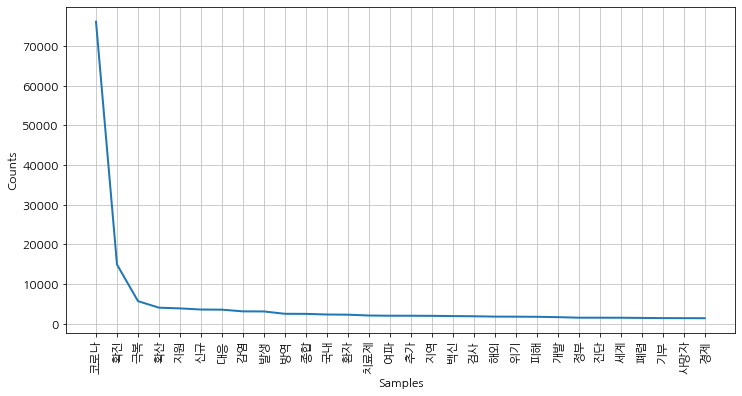

워드 클라우드 저장 완료 !!


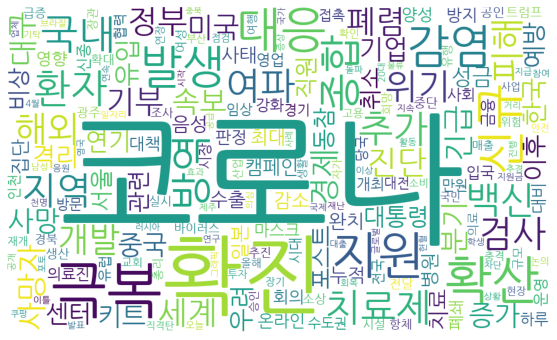

In [62]:
############################################################################################
## koNLPy의 형태소 분석기와 NLTK의 Text 클래스를 결합하여 NLTK 기능을 사용할 수도 있다.
############################################################################################
from nltk import Text
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# plt.rcParams['font.family'] ='NanumGothic'
plt.rc('font', family='NanumGothic') ## 글꼴
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.xlabel('키워드')

text = Text(kopus, name="단어")

#text.vocab()
chart = text.plot(30)

# chart.savefig(f'{current_work}_chart.png')
# print('이미지 저장 완료!!')

##############################################################################################
## wordcloud #################################################################################
##############################################################################################
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 자신의 컴퓨터 환경에 맞는 한글 폰트 경로를 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

plt.rc('font', family='NanumGothic') ## 글꼴
wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_path)
plt.imshow(wc.generate_from_frequencies(text.vocab()))
plt.axis("off")

plt.savefig(f'{current_work}_wordcloud.png')
print('워드 클라우드 저장 완료 !!')

In [39]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

## Word2Vec 훈련시키기 #####################################################################################
#type(kopus_result) ##list
# word2vec_model = Word2Vec(sentences=kopus_result, vector_size=100, window=5, min_count=5, workers=4, sg=0)
model = Word2Vec(sentences=token_result, size=100, window=5, min_count=2, workers=4, sg=1)


In [63]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(11367, 100)

In [64]:
model.wv.vectors

array([[-0.29485062,  0.49996033, -0.07626396, ...,  0.09040827,
        -0.36884308,  0.15358509],
       [-0.14461984,  0.01215601, -0.35196143, ..., -0.35281843,
        -0.39698207,  0.09384418],
       [ 0.71569127,  0.8178729 , -0.40946433, ...,  0.51416856,
         0.603033  ,  0.45639908],
       ...,
       [-0.06477582, -0.03997104, -0.029424  , ..., -0.02408524,
         0.04218044, -0.00788941],
       [-0.03032764, -0.01385401, -0.01267938, ..., -0.01415838,
         0.02430383, -0.00406656],
       [-0.17890078,  0.00587373, -0.00257063, ...,  0.04208568,
         0.11792528,  0.01350756]], dtype=float32)

In [ ]:
## Word2Vec ################################################################
## model.wv.most_similar: 입력한 단어에 대해서 가장 유사한 단어들 출력
############################################################################
model_result = model.wv.most_similar("코로나")
print(model_result)

[('대구경북', 0.5950508117675781), ('자리', 0.5869260430335999), ('기초', 0.5846017599105835), ('남부', 0.584336519241333), ('이어', 0.5823009014129639), ('7월 10일', 0.5771531462669373), ('이중', 0.5748847126960754), ('7월 30일', 0.5687723159790039), ('민간', 0.5662405490875244), ('지난', 0.566074788570404)]


In [66]:
model.wv.most_similar("코로나")

[('대구경북', 0.5950508117675781),
 ('자리', 0.5869260430335999),
 ('기초', 0.5846017599105835),
 ('남부', 0.584336519241333),
 ('이어', 0.5823009014129639),
 ('7월 10일', 0.5771531462669373),
 ('이중', 0.5748847126960754),
 ('7월 30일', 0.5687723159790039),
 ('민간', 0.5662405490875244),
 ('지난', 0.566074788570404)]

In [67]:
## 코로나와 관련된 TOP 30 추출
model.wv.most_similar('코로나', topn=30)

[('대구경북', 0.5950508117675781),
 ('자리', 0.5869260430335999),
 ('기초', 0.5846017599105835),
 ('남부', 0.584336519241333),
 ('이어', 0.5823009014129639),
 ('7월 10일', 0.5771531462669373),
 ('이중', 0.5748847126960754),
 ('7월 30일', 0.5687723159790039),
 ('민간', 0.5662405490875244),
 ('지난', 0.566074788570404),
 ('참가자', 0.5633029341697693),
 ('정리', 0.5619741678237915),
 ('가운데', 0.5611116290092468),
 ('일희일비', 0.5610224008560181),
 ('재가', 0.5608706474304199),
 ('5월 31일', 0.5569031238555908),
 ('각지', 0.5544372797012329),
 ('엉터리', 0.5536015629768372),
 ('21', 0.5531676411628723),
 ('5월 25일', 0.5525851249694824),
 ('골든크로스', 0.5522057414054871),
 ('분당', 0.5520172119140625),
 ('장점', 0.5515835881233215),
 ('가락시장', 0.551562488079071),
 ('만리장성', 0.5513365268707275),
 ('캘리포니아주', 0.5505578517913818),
 ('도미노', 0.5504280924797058),
 ('걸프', 0.5503270626068115),
 ('시간문제', 0.5503188371658325),
 ('설명', 0.5493086576461792)]

In [68]:
keyword = '위해'

table_1.기사제목[table_1.기사제목.str.contains(keyword)]

216                  시흥시, 신종 코로나 대응 위해 2월 계획된 행사 전면 취소
232                  동구, '신종 코로나' 확산 방지 위해 각종 행사 전면 취소
257                         인천시, 코로나바이러스 확산방지 위해 총력 대응
263               대전 동구, '신종 코로나' 확산 방지 위해 각종 행사 전면 취소
341               대전 동구, '신종 코로나' 확산 방지 위해 각종 행사 전면 취소
                             ...                      
78179      '비긴어게인' 코로나19로 싸우는 영웅들을 위해 소향, '널 사랑하는걸' 선곡
78235                      KB증권, 코로나19 극복을 위해 무지개교실 열어
78372                조선대, 코로나19 극복 위해 2학기 등록금 11.5% 감면
78538    서울시교육청, 코로나19 확산 방지 위해 수시전형 대비 특별진학상담 비대면 ...
78602                       KB증권, 코로나19 극복 위해 무지개교실 열어
Name: 기사제목, Length: 1737, dtype: object

In [69]:
keyword = '천'

keyword_search = table_1.기사제목[table_1.기사제목.str.contains(keyword)]
print('개수 >>', len(keyword_search))
keyword_search


개수 >> 3932


79                               인천시, '신종 코로나' 확진자 1명 그대로
103                       신종코로나 확진자 6명 모두 서울·경기·인천 수도권 지역
111                       인천 신종 코로나 격리자 이틀새 2.5배↑…18명→46명
115                         '신종코로나 비상'…인천 차이나타운에 관광객 발길 뚝
126                              인천시, '신종 코로나' 확진자 1명 그대로
                               ...                       
78454                         [포토]코로나19로 활기 잃은 인천국제공항 출국장
78488                       순천 코로나 확진자 발생… 부산 157번째 접촉 추정
78520                  [경남소식] 3만5천개 소상공 사업장 코로나19 위기 실태조사
78552    [국내 코로나19] 감염 36명 늘어 총 1만4천598명.. 국내감염 해외유입보다 5배
78581                              '코로나19 우려'…김천전국수영대회 연기
Name: 기사제목, Length: 3932, dtype: object

In [ ]:
## 1. n-gram #######################################
token = list(tf_idf_final.index)
token_len = len(token)
n_gram = []

for idx, out_token in enumerate(token, 1):
    #print('out_token>>', out_token)
    
    if idx == token_len:
        break
        
    for in_token in token[idx:]:
        #print('\tin_token>>', in_token)
        n_gram.append((out_token, in_token))
        
n_gram        

# n_gram[:10]

[('확진', '극복'),
 ('확진', '지원'),
 ('확진', '확산'),
 ('확진', '감염'),
 ('확진', '대응'),
 ('확진', '신규'),
 ('확진', '발생'),
 ('확진', '치료'),
 ('확진', '사망'),
 ('확진', '방역'),
 ('확진', '종합'),
 ('확진', '환자'),
 ('확진', '국내'),
 ('확진', '치료제'),
 ('확진', '지역'),
 ('확진', '추가'),
 ('확진', '여파'),
 ('확진', '검사'),
 ('확진', '백신'),
 ('확진', '피해'),
 ('확진', '해외'),
 ('확진', '위기'),
 ('확진', '정부'),
 ('확진', '세계'),
 ('확진', '개발'),
 ('확진', '대구'),
 ('확진', '한국'),
 ('확진', '기부'),
 ('확진', '기업'),
 ('극복', '지원'),
 ('극복', '확산'),
 ('극복', '감염'),
 ('극복', '대응'),
 ('극복', '신규'),
 ('극복', '발생'),
 ('극복', '치료'),
 ('극복', '사망'),
 ('극복', '방역'),
 ('극복', '종합'),
 ('극복', '환자'),
 ('극복', '국내'),
 ('극복', '치료제'),
 ('극복', '지역'),
 ('극복', '추가'),
 ('극복', '여파'),
 ('극복', '검사'),
 ('극복', '백신'),
 ('극복', '피해'),
 ('극복', '해외'),
 ('극복', '위기'),
 ('극복', '정부'),
 ('극복', '세계'),
 ('극복', '개발'),
 ('극복', '대구'),
 ('극복', '한국'),
 ('극복', '기부'),
 ('극복', '기업'),
 ('지원', '확산'),
 ('지원', '감염'),
 ('지원', '대응'),
 ('지원', '신규'),
 ('지원', '발생'),
 ('지원', '치료'),
 ('지원', '사망'),
 ('지원', '방역'),
 ('지원', '종합'),
 ('지원', 

In [71]:
## 2. 어휘 동시 출현 빈도의 계수화 #######################################
co_occurrence = {}

for token_element in token_result:
    for n in n_gram:
        compare = set(token_element) & set(n)
        if len(compare) == 2:
            co_occurrence[n] = co_occurrence.get(n, 0) + 1
            
co_occurrence

{('감염', '개발'): 40,
 ('감염', '검사'): 49,
 ('감염', '국내'): 122,
 ('감염', '기부'): 3,
 ('감염', '기업'): 7,
 ('감염', '대구'): 46,
 ('감염', '대응'): 16,
 ('감염', '발생'): 175,
 ('감염', '방역'): 74,
 ('감염', '백신'): 14,
 ('감염', '사망'): 100,
 ('감염', '세계'): 36,
 ('감염', '신규'): 429,
 ('감염', '여파'): 26,
 ('감염', '위기'): 9,
 ('감염', '정부'): 23,
 ('감염', '종합'): 180,
 ('감염', '지역'): 327,
 ('감염', '추가'): 120,
 ('감염', '치료'): 13,
 ('감염', '치료제'): 10,
 ('감염', '피해'): 7,
 ('감염', '한국'): 21,
 ('감염', '해외'): 119,
 ('감염', '환자'): 83,
 ('개발', '기부'): 14,
 ('개발', '기업'): 39,
 ('개발', '대구'): 8,
 ('개발', '한국'): 9,
 ('검사', '개발'): 18,
 ('검사', '기부'): 1,
 ('검사', '기업'): 2,
 ('검사', '대구'): 30,
 ('검사', '백신'): 6,
 ('검사', '세계'): 12,
 ('검사', '위기'): 1,
 ('검사', '정부'): 43,
 ('검사', '피해'): 1,
 ('검사', '한국'): 45,
 ('검사', '해외'): 13,
 ('국내', '개발'): 44,
 ('국내', '검사'): 21,
 ('국내', '기업'): 49,
 ('국내', '대구'): 89,
 ('국내', '백신'): 92,
 ('국내', '세계'): 21,
 ('국내', '여파'): 34,
 ('국내', '위기'): 31,
 ('국내', '정부'): 13,
 ('국내', '지역'): 91,
 ('국내', '추가'): 111,
 ('국내', '치료제'): 159,
 ('국내', '피해

In [72]:
## 2. 어휘 동시 출현 빈도의 계수화 #######################################
co_occurrence = {}

for token_element in token_result:
    for n in n_gram:
        compare = set(token_element) & set(n)
        if len(compare) == 2:
            co_occurrence[n] = co_occurrence.get(n, 0) + 1
            
co_occurrence

{('감염', '개발'): 40,
 ('감염', '검사'): 49,
 ('감염', '국내'): 122,
 ('감염', '기부'): 3,
 ('감염', '기업'): 7,
 ('감염', '대구'): 46,
 ('감염', '대응'): 16,
 ('감염', '발생'): 175,
 ('감염', '방역'): 74,
 ('감염', '백신'): 14,
 ('감염', '사망'): 100,
 ('감염', '세계'): 36,
 ('감염', '신규'): 429,
 ('감염', '여파'): 26,
 ('감염', '위기'): 9,
 ('감염', '정부'): 23,
 ('감염', '종합'): 180,
 ('감염', '지역'): 327,
 ('감염', '추가'): 120,
 ('감염', '치료'): 13,
 ('감염', '치료제'): 10,
 ('감염', '피해'): 7,
 ('감염', '한국'): 21,
 ('감염', '해외'): 119,
 ('감염', '환자'): 83,
 ('개발', '기부'): 14,
 ('개발', '기업'): 39,
 ('개발', '대구'): 8,
 ('개발', '한국'): 9,
 ('검사', '개발'): 18,
 ('검사', '기부'): 1,
 ('검사', '기업'): 2,
 ('검사', '대구'): 30,
 ('검사', '백신'): 6,
 ('검사', '세계'): 12,
 ('검사', '위기'): 1,
 ('검사', '정부'): 43,
 ('검사', '피해'): 1,
 ('검사', '한국'): 45,
 ('검사', '해외'): 13,
 ('국내', '개발'): 44,
 ('국내', '검사'): 21,
 ('국내', '기업'): 49,
 ('국내', '대구'): 89,
 ('국내', '백신'): 92,
 ('국내', '세계'): 21,
 ('국내', '여파'): 34,
 ('국내', '위기'): 31,
 ('국내', '정부'): 13,
 ('국내', '지역'): 91,
 ('국내', '추가'): 111,
 ('국내', '치료제'): 159,
 ('국내', '피해

In [73]:
## 3-1. 어휘 동시 출현 빈도를 데이터프레임으로 변환 #############################
df_co_occurrence = pd.DataFrame.from_dict(co_occurrence, orient='index', columns=['빈도'])
df_co_occurrence[:30].sort_index()
df_co_occurrence[:30].sort_values(by='빈도', ascending=False)

,빈도
"(확진, 발생)",2321
"(확진, 추가)",1366
"(확진, 국내)",1156
"(확진, 감염)",986
"(확진, 지역)",852
"(확진, 종합)",805
"(지원, 피해)",757
"(확진, 환자)",544
"(발생, 국내)",523
"(확진, 확산)",394


In [74]:
## 3-2. 어휘 동시 출현 빈도를 데이터프레임으로 변환 : 멀티 인덱스로 변환 #############################
copy_df_co_occurrence = df_co_occurrence.copy()
copy_df_co_occurrence.index = pd.MultiIndex.from_tuples(copy_df_co_occurrence.index)
copy_df_co_occurrence

빈도
확진  환자    544
    발생   2321
    국내   1156
    추가   1366
발생  국내    523
...       ...
사망  치료제     1
지역  백신      2
치료제 대구      1
백신  피해      1
치료  해외      1

[411 rows x 1 columns]

In [75]:
df_co_occurrence['빈도'][0]

544

In [76]:
list_df_co_occurrence = []

for idx in range(len(df_co_occurrence)):
    #index를 중심으로 계속 중첩해서 list에 넣는다 
    list_df_co_occurrence.append([df_co_occurrence.index[idx][0],
                                  df_co_occurrence.index[idx][1],
                                  df_co_occurrence['빈도'][idx]])

list_df_co_occurrence

df2_co_occurrence = pd.DataFrame(list_df_co_occurrence, columns=['term1', 'term2', 'freq'])
df2_co_occurrence
df2_co_occurrence.sort_values(by=['freq'], ascending=False)
final_co_occurrence = df2_co_occurrence.sort_values(by=['freq'], ascending=False)
final_co_occurrence

,term1,term2,freq
160,확진,신규,3174
1,확진,발생,2321
3,확진,추가,1366
2,확진,국내,1156
70,확진,해외,1044
...,...,...,...
371,검사,위기,1
372,치료,기업,1
390,발생,개발,1
389,치료,한국,1


In [78]:
## 차트

import numpy as np
import networkx as nx
import operator

## 단어 네트워크 Graph
G=nx.Graph()


## 페이지 랭크에 따라 두 노드 사이 연관성 결정(단어쌍의 연관성)
## 연결 중심성으로 계산한 척도에 따라 노드의 크기 결정(단어 등장 빈도수)
for i in range(len(final_co_occurrence)):
    G.add_edge(final_co_occurrence['term1'][i], 
               final_co_occurrence['term2'][i], 
               weight=int(final_co_occurrence['freq'][i]))

# Compute centralities for nodes.
# The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.
dgr = nx.degree_centrality(G)          ## 연결 중심성
btw = nx.betweenness_centrality(G)     ## 매개 중심성
cls = nx.closeness_centrality(G)       ## 근접 중심성

# itemgetter(0): key 또는 itemgetter(1): value로 sort key, reverse=True (descending order)
sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)

print("** degree **")
for x in range(20):
    print(sorted_dgr[x])

print("** betweenness **")
for x in range(20):
    print(sorted_btw[x])

print("** closeness **")
for x in range(20):
    print(sorted_cls[x])


for idx in range(len(sorted_cls)):
    G.add_node(sorted_cls[idx][0], nodesize=sorted_cls[idx][1])
#     G.add_node(sorted_btw[idx][0], nodesize=sorted_btw[idx][1])
#     G.add_node(sorted_dgr[idx][0], nodesize=sorted_dgr[idx][1])
    
for idx in range(len(sorted_cls)):
    G.add_weighted_edges_from([(final_co_occurrence['term1'][idx],
                               final_co_occurrence['term2'][idx],
                               #int(final_co_occurrence['freq'][idx]))
                               int(sorted_cls[idx][1]))
                              ])




** degree **
('확진', 1.0)
('추가', 1.0)
('확산', 1.0)
('종합', 1.0)
('대응', 1.0)
('정부', 1.0)
('지원', 1.0)
('감염', 1.0)
('세계', 1.0)
('방역', 1.0)
('한국', 1.0)
('해외', 1.0)
('국내', 0.9655172413793103)
('검사', 0.9655172413793103)
('대구', 0.9655172413793103)
('지역', 0.9655172413793103)
('신규', 0.9655172413793103)
('발생', 0.9310344827586207)
('기업', 0.9310344827586207)
('개발', 0.9310344827586207)
** betweenness **
('확진', 0.0025507172915611555)
('추가', 0.0025507172915611555)
('확산', 0.0025507172915611555)
('종합', 0.0025507172915611555)
('대응', 0.0025507172915611555)
('정부', 0.0025507172915611555)
('지원', 0.0025507172915611555)
('감염', 0.0025507172915611555)
('세계', 0.0025507172915611555)
('방역', 0.0025507172915611555)
('한국', 0.0025507172915611555)
('해외', 0.0025507172915611555)
('대구', 0.0022360688857797446)
('국내', 0.002127892989426508)
('신규', 0.002127892989426508)
('검사', 0.0020042604643161505)
('지역', 0.0020042604643161505)
('발생', 0.0018094552695109558)
('환자', 0.0017045888715411098)
('기업', 0.0015528766942345866)
** closenes

In [79]:
sorted_cls[0][1]
final_co_occurrence['term1'][0]
final_co_occurrence['term2'][0]

'환자'

In [80]:
sorted_cls

[('확진', 1.0),
 ('추가', 1.0),
 ('확산', 1.0),
 ('종합', 1.0),
 ('대응', 1.0),
 ('정부', 1.0),
 ('지원', 1.0),
 ('감염', 1.0),
 ('세계', 1.0),
 ('방역', 1.0),
 ('한국', 1.0),
 ('해외', 1.0),
 ('국내', 0.9666666666666667),
 ('검사', 0.9666666666666667),
 ('대구', 0.9666666666666667),
 ('지역', 0.9666666666666667),
 ('신규', 0.9666666666666667),
 ('발생', 0.9354838709677419),
 ('기업', 0.9354838709677419),
 ('개발', 0.9354838709677419),
 ('환자', 0.90625),
 ('피해', 0.90625),
 ('위기', 0.90625),
 ('치료', 0.90625),
 ('백신', 0.90625),
 ('극복', 0.90625),
 ('여파', 0.8787878787878788),
 ('기부', 0.8787878787878788),
 ('치료제', 0.8529411764705882),
 ('사망', 0.8285714285714286)]

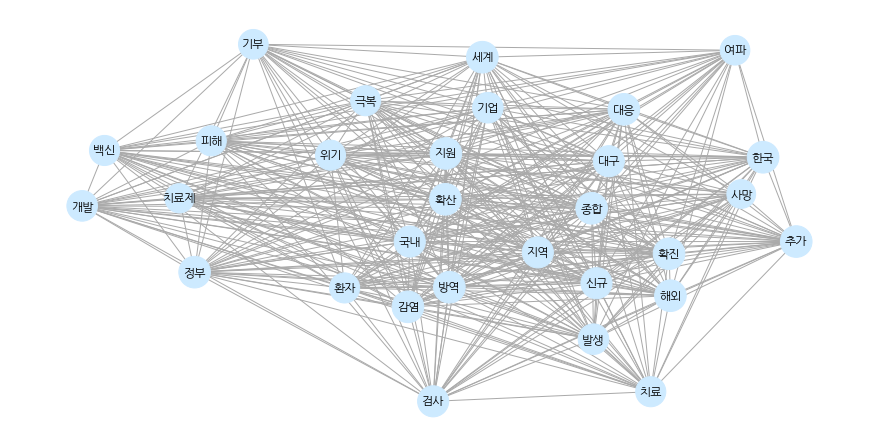

<<table_1 이미지 저장 완료 >>


<Figure size 864x432 with 0 Axes>

In [81]:
## 노드 크기 결정
size = [G.nodes[node]['nodesize'] * 1000 for node in G]

options = {
    'node_color': '#CDEAFF',
    'edge_color': '#aaa',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}

## 폰트 설정을 위한 font_manager import
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

## 폰트 설정
# plt.rcParams['font.family'] ='Malgun Gothic'
plt.rc('font', family='NanumGothic') ## 글꼴

## 
nx.draw(G, 
        node_size=size,
        #pos=nx.spring_layout(G, k=5.2, iterations=100),
        pos=nx.spring_layout(G, k=10, iterations=100),
        #pos=nx.spring_layout(G),
        #pos=nx.shell_layout(G),
        **options,
        # font_family='Malgun Gothic',
        font_family='NanumGothic',
        #alpha=0.8,
        #cmap=plt.cm.cmap_d,
       )

ax = plt.gca()
# ax.collections[0].set_edgecolor('#eee')
plt.show()
plt.savefig('network.svg')
print('<<table_1 이미지 저장 완료 >>')